<a href="https://colab.research.google.com/github/raywisecreativity/GANs-project/blob/main/fashion_forge_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion Forge

# 1. Setting up Environment

In [ ]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import tensorflow as tf
print("Check my GPU", tf.config.list_physical_devices("GPU"))

Check my GPU [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configured with memory growth")
else:
    print("No GPU detected")

GPU configured with memory growth


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# 2. Import Dataset and Check it

### This loads the fashion MNIST dataset

(X_train, y_train) (X_test, y_test)

_ discards the test dataset because we only need the training images

Values between 0 and 255 → Different shades of gray

0   → Black
127 → Medium Gray
255 → White

In [ ]:
(X_train, _), (_, _) = keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print("Data shape",X_train.shape)

Data shape (60000, 28, 28)


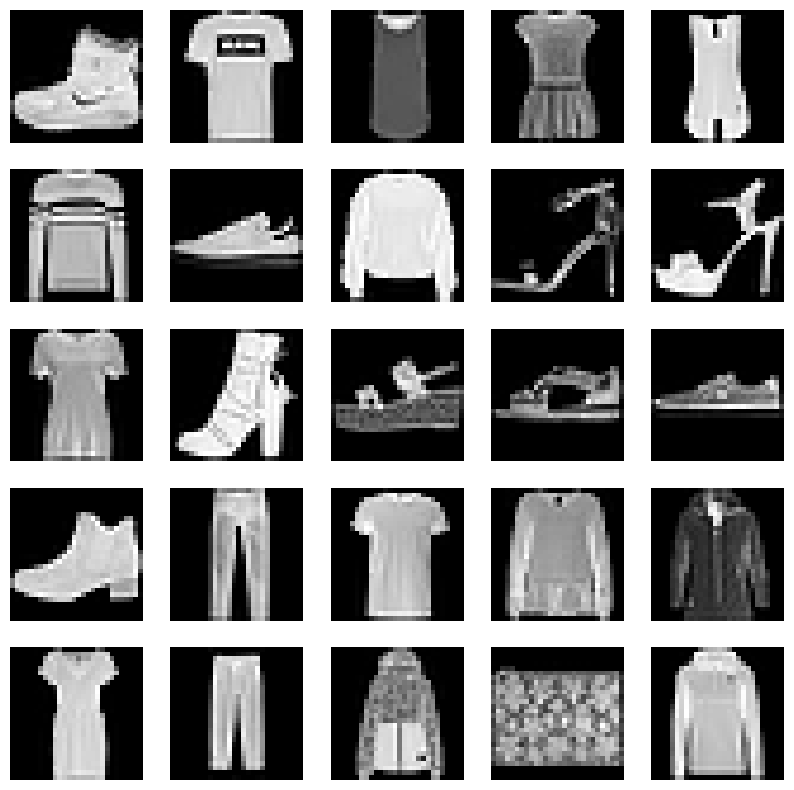

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(X_train[i], cmap="gray")
  plt.axis("off")
plt.show()

# 3. Create a Data Pipeline

In [ ]:
X_train.shape[0]

60000

### Normalizing the data

X_train.shape[0] → Represents the number of images (60,000 in Fashion MNIST). 28, 28 → The images are 28×28 pixels (grayscale). 1 → The extra dimension is added to indicate one color channel (grayscale).

astype("float32") -> convert them to floating point numbers, which are needed for our neural network to work efficiently

X_train = (X_train - 127.5) / 127.5

The pixex value are originally stored as integer (0-255), GANs work better in the range [-1, 1] instead of [0, 255]

In [ ]:
# Normalise and reshape the data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype("float32")
X_train = (X_train - 127.5) / 127.5

In [ ]:
X_train.shape

(60000, 28, 28, 1)

BUFFER_SIZE = 60000:
Ensures complete shuffling of the dataset every epoch for diverse training.

BATCH_SIZE = 256:
Determines the number of images processed at once, balancing memory usage and training speed.

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
X_train

array([[[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        ...,

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]]],


       [[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [

Before batching (60000, 28, 28, 1) -> 60,000 individual images

After batching (256, 28, 28, 1) Each batch contain 256 images

Total number of batch per epoch would be -> 60000/256 = 235

-> Coverting X_train into a Tensorflow dataset

-> Shuffles the dataset (to prevent order bias)

-> Batches the dataset into group of 256 images for efficient training

In [ ]:
# Create the tensorflow dstaset
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

mean=0.0 is commonly used in GANs, sometimes a small non-zero mean can improve stability.

Default → mean=0.0 (safe, but can be improved). Better choice → mean=0.01 or mean=0.02 for faster and more stable training.

Why stddev=0.02?

Based on research (from DCGAN paper), stddev=0.02 helps GANs generate sharper images. Ensures the network starts with balanced gradients.

In [ ]:
LATENT_DIM = 100
WEIGHT_UNIT = keras.initializers.RandomNormal(mean=0.01, stddev=0.02)

# 4. Create a Generator and a Discriminator

In [ ]:
def build_generator():
  model = keras.Sequential([
    layers.Dense(7*7*256, use_bias=False, input_shape=(LATENT_DIM,)),
    layers.BatchNormalization(), # normalize the activation of the previous layer
    layers.LeakyReLU(),

    layers.Reshape((7, 7, 256)),

    layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
  ])
  return model

generator = build_generator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# build our discriminator
def build_discriminator():
  model = keras.Sequential([
      # First COnv2d layer: Detect low level features in the images (edges, textures, ...)
      layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]),

      # LeakyRelu activation function to avoid dead neurons and allow negative gradients
      layers.LeakyReLU(0.2),
      # dropout to prevent overfitting and improve generalization
      layers.Dropout(0.3),

      # First COnv2d layer: learn more complex feature from the images
      layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
      layers.LeakyReLU(0.2),
      layers.Dropout(0.3),

      # Flatten the 2D feature maps into a 1D vector for the Dense layer
      layers.Flatten(),

      layers.Dense(1, activation='sigmoid')

  ])

  return model

discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cross_entropy = keras.losses.BinaryCrossentropy()

### Create the generator amd discriminator losses

In [ ]:
# Create the discriminator loss
def discriminator_loss(real_output, fake_output):
  # calculates the loss when the discriminator classify fake images
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)

  #ccalculate the loss when the discriminator classifies fake images
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

 # Return the sum of both losses
  return real_loss + fake_loss

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)

### Building a Sub class model

In [ ]:
# Building our sub ckass model
class GAN(keras.Model):
  def __init__(self, generator, discriminator):
    # initilize the GAN model  with the generator and discriminator
    super(GAN, self).__init__()
    self.generator = generator #set genrator model
    self.discriminator = discriminator # set discriminator moel


  def compile(self, g_optimizer, d_optimizer, g_loss, d_loss):
    super(GAN, self).compile()
    self.g_optimizer = g_optimizer # set the generator optimizer
    self.d_optimizer = d_optimizer # set the discriminator optimizer
    self.g_loss = g_loss # set the generator loss
    self.d_loss = d_loss # set the discriminator loss


  def train_step(self, real_images):
    # Training logic
    batch_size = tf.shape(real_images)[0]

    # Train discriminator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as d_tape:
        generated_images = self.generator(noise)
        real_output = self.discriminator(real_images)
        fake_output = self.discriminator(generated_images)
        d_loss = self.d_loss(real_output, fake_output)

    # Cimputing the gradients for the discriminator based in its loss
    d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
    self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

    # Train generator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as g_tape:
        generated_images = self.generator(noise)
        fake_output = self.discriminator(generated_images)
        g_loss = self.g_loss(fake_output)

    g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
    self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

    return {"d_loss": d_loss, "g_loss": g_loss}

In [ ]:
class ImageCallback(keras.callbacks.Callback):
  def __init__(self, num_images=16, latent_dim=100):
    self.num_images = num_images
    self.latent_dim = latent_dim
    self.seed = tf.random.normal([num_images, latent_dim])

  def on_epoch_end(self, epoch, logs=None):
    if epoch % 5 == 0:
      generated_images = self.model.generator(self.seed)
      generated_images = (generated_images * 127.5) + 127.5 #rescaleto range [0, 233]

      plt.figure(figsize=(10,10))
      for i in range(self.num_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i].numpy().astype("uint8"), cmap="gray")
        plt.axis("off")
      plt.show()

# 5. Train the Dataset

In [ ]:
EPOCH = 100

In [ ]:
gan = GAN(generator=generator, discriminator=discriminator)

gan.compile(
    g_optimizer=generator_optimizer,
    d_optimizer=discriminator_optimizer,
    g_loss=generator_loss,
    d_loss=discriminator_loss
)

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - d_loss: 1.2062 - g_loss: 0.8439

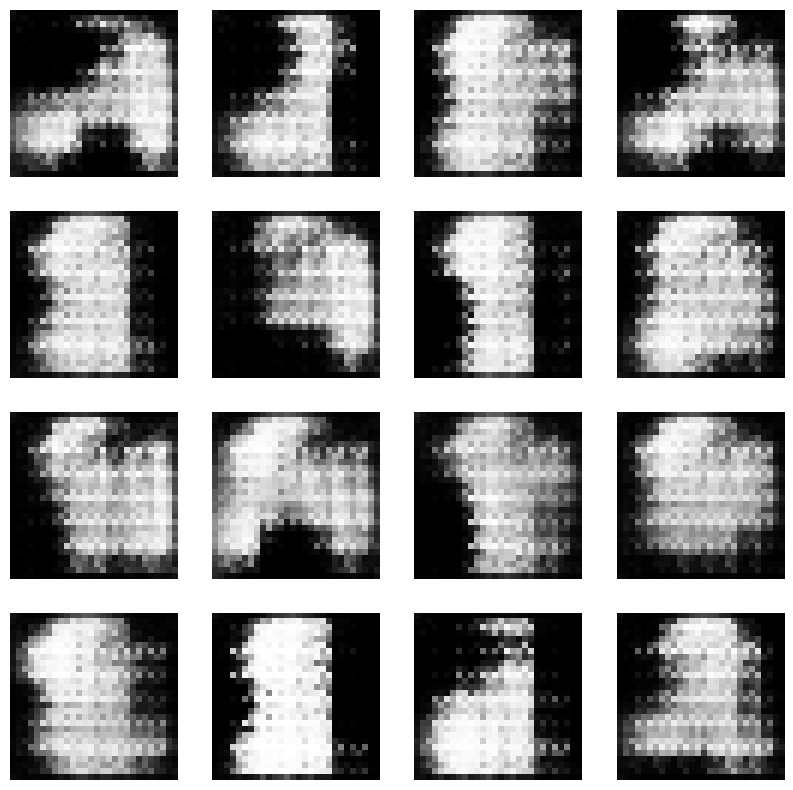

235/235 ━━━━━━━━━━━━━━━━━━━━ 33s 87ms/step - d_loss: 1.2072 - g_loss: 0.8430
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - d_loss: 1.3193 - g_loss: 0.7926
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - d_loss: 1.2980 - g_loss: 0.8099
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - d_loss: 1.2474 - g_loss: 0.8661
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.2444 - g_loss: 0.8957
Epoch 6/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - d_loss: 1.3178 - g_loss: 0.7999

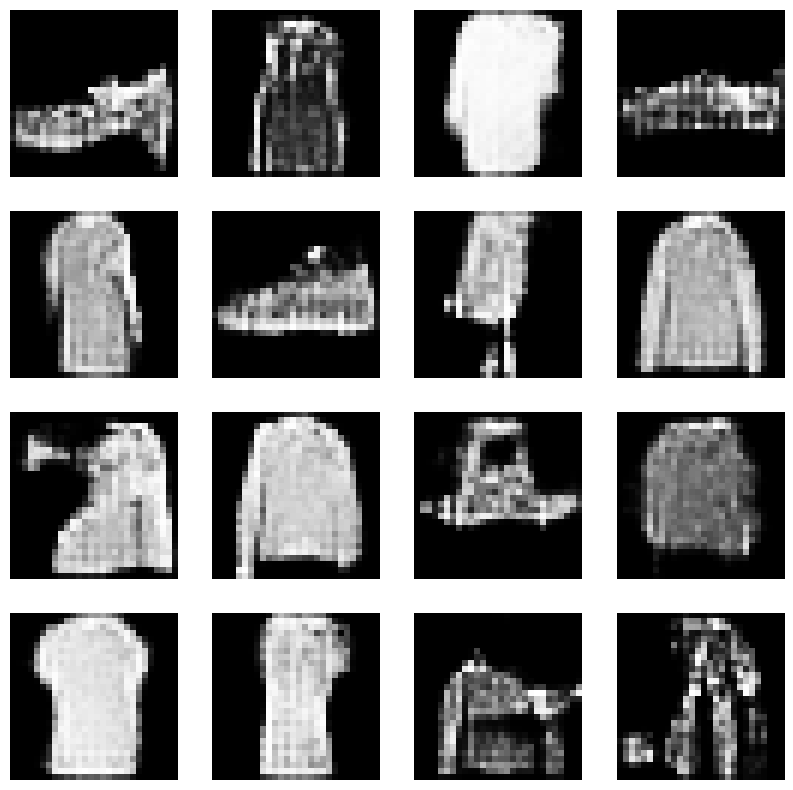

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - d_loss: 1.3180 - g_loss: 0.7992
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3283 - g_loss: 0.7770
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3384 - g_loss: 0.7688
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3326 - g_loss: 0.7645
Epoch 10/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3353 - g_loss: 0.7657
Epoch 11/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - d_loss: 1.3359 - g_loss: 0.7732

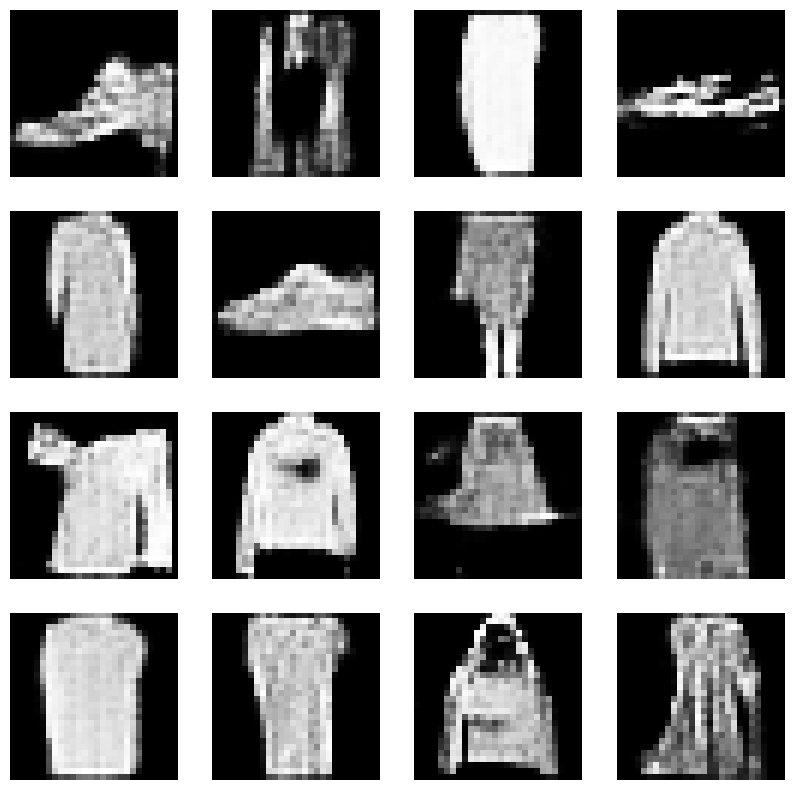

235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3359 - g_loss: 0.7733
Epoch 12/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3324 - g_loss: 0.7637
Epoch 13/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3372 - g_loss: 0.7675
Epoch 14/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3376 - g_loss: 0.7644
Epoch 15/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3394 - g_loss: 0.7655
Epoch 16/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - d_loss: 1.3439 - g_loss: 0.7645

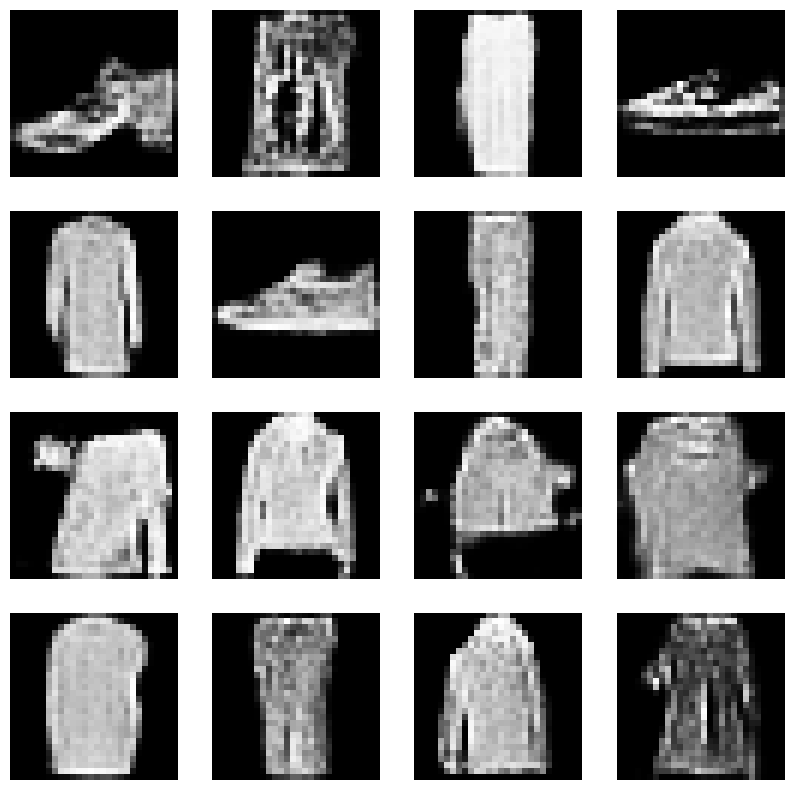

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - d_loss: 1.3440 - g_loss: 0.7651
Epoch 17/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3429 - g_loss: 0.7601
Epoch 18/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3436 - g_loss: 0.7579
Epoch 19/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3469 - g_loss: 0.7607
Epoch 20/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - d_loss: 1.3451 - g_loss: 0.7586
Epoch 21/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - d_loss: 1.3456 - g_loss: 0.7624

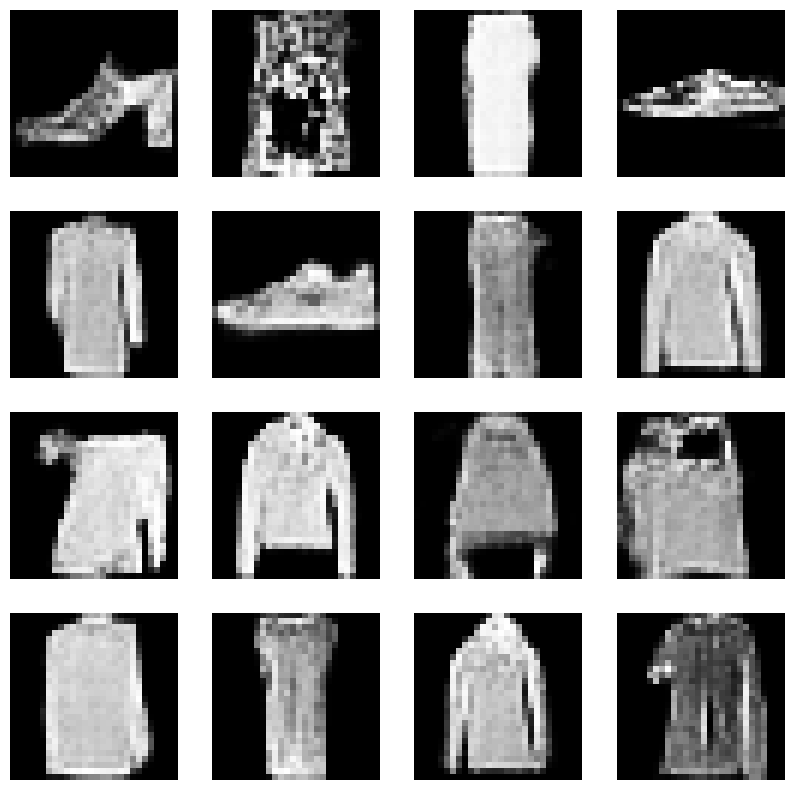

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - d_loss: 1.3457 - g_loss: 0.7624
Epoch 22/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3472 - g_loss: 0.7684
Epoch 23/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3438 - g_loss: 0.7597
Epoch 24/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3441 - g_loss: 0.7596
Epoch 25/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3432 - g_loss: 0.7555
Epoch 26/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - d_loss: 1.3454 - g_loss: 0.7655

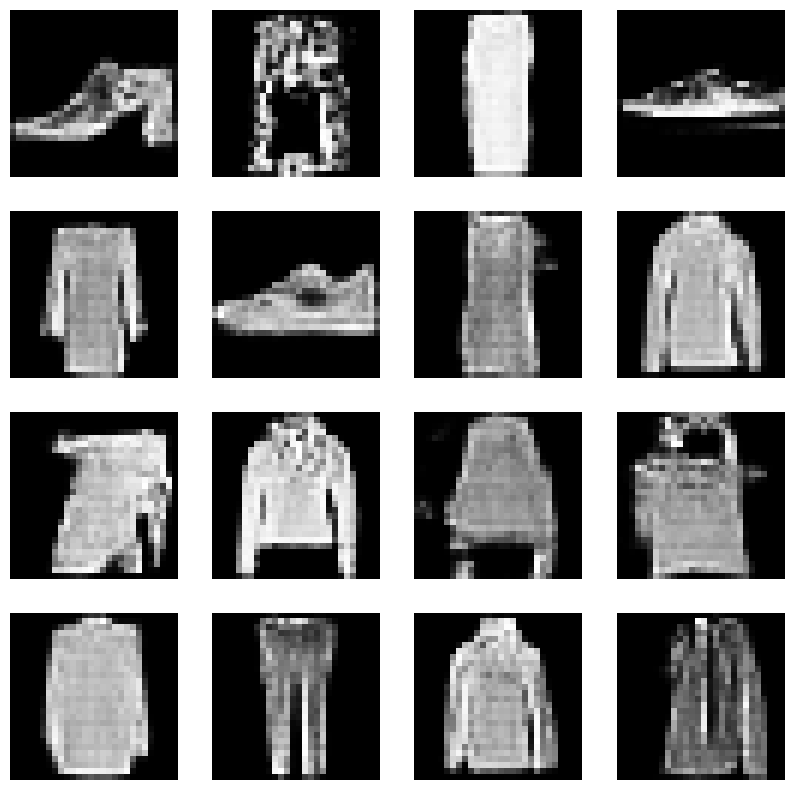

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - d_loss: 1.3451 - g_loss: 0.7648
Epoch 27/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3449 - g_loss: 0.7666
Epoch 28/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3420 - g_loss: 0.7572
Epoch 29/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3434 - g_loss: 0.7612
Epoch 30/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3439 - g_loss: 0.7600
Epoch 31/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - d_loss: 1.3424 - g_loss: 0.7591

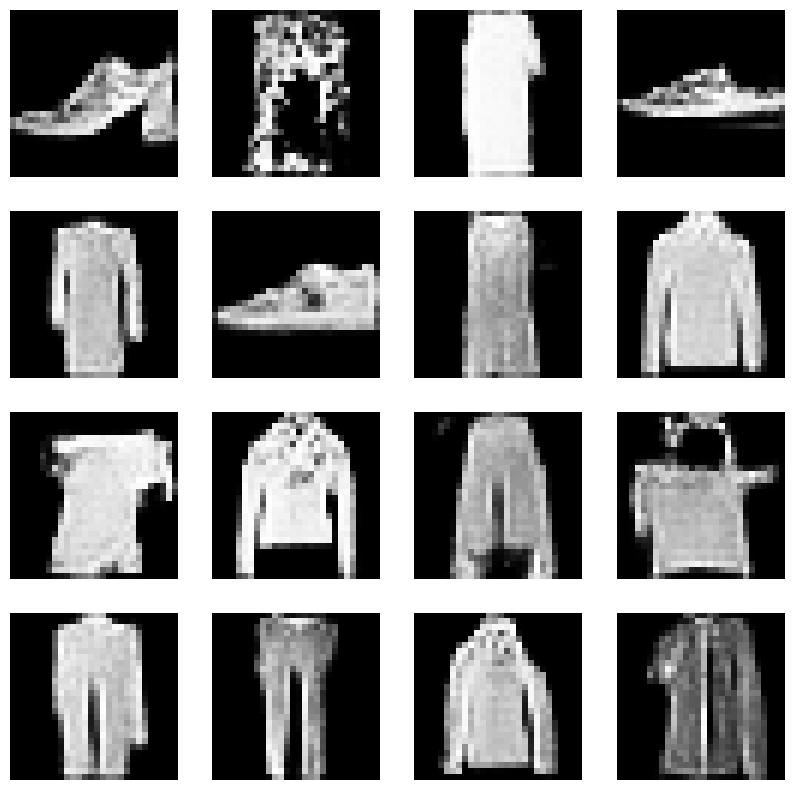

235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3425 - g_loss: 0.7582
Epoch 32/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3433 - g_loss: 0.7643
Epoch 33/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - d_loss: 1.3429 - g_loss: 0.7606
Epoch 34/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3433 - g_loss: 0.7619
Epoch 35/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3424 - g_loss: 0.7619
Epoch 36/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - d_loss: 1.3425 - g_loss: 0.7664

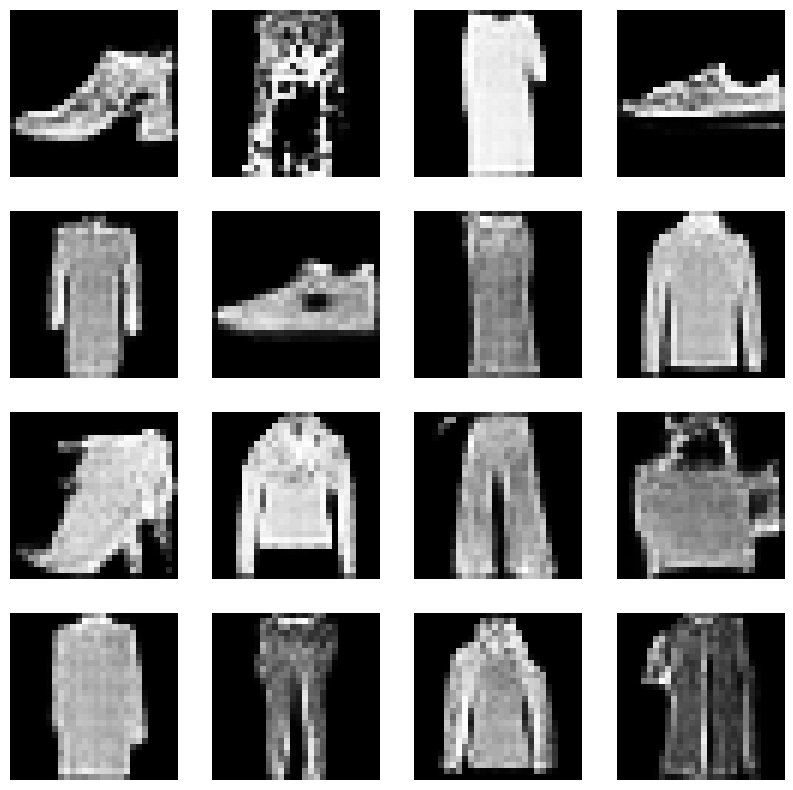

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - d_loss: 1.3425 - g_loss: 0.7661
Epoch 37/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3420 - g_loss: 0.7618
Epoch 38/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3397 - g_loss: 0.7606
Epoch 39/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3436 - g_loss: 0.7626
Epoch 40/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3378 - g_loss: 0.7630
Epoch 41/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - d_loss: 1.3374 - g_loss: 0.7660

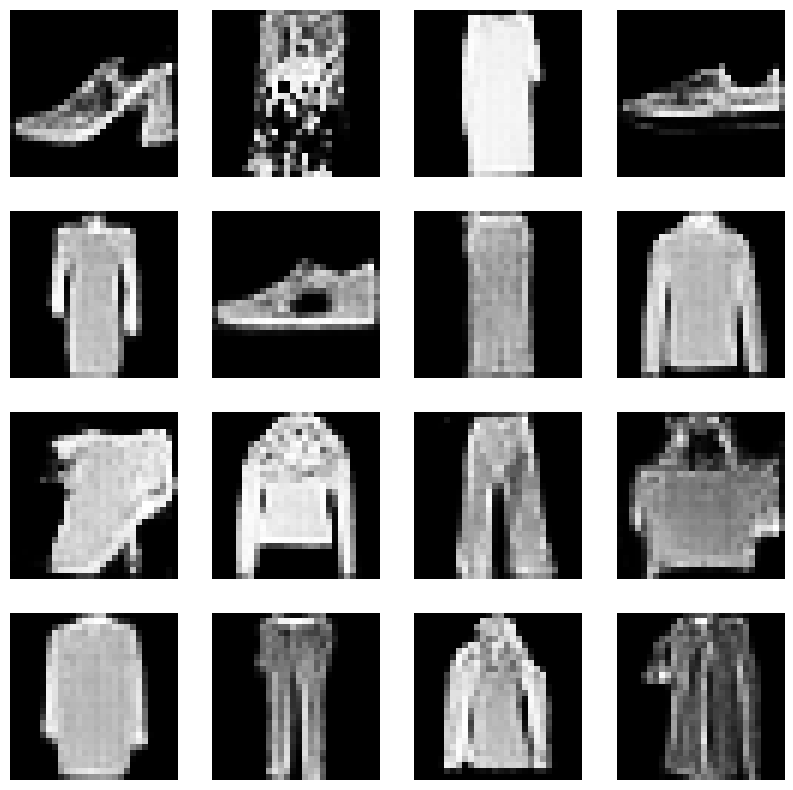

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - d_loss: 1.3375 - g_loss: 0.7656
Epoch 42/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3403 - g_loss: 0.7660
Epoch 43/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - d_loss: 1.3389 - g_loss: 0.7620
Epoch 44/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - d_loss: 1.3366 - g_loss: 0.7621
Epoch 45/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3345 - g_loss: 0.7683
Epoch 46/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - d_loss: 1.3368 - g_loss: 0.7674

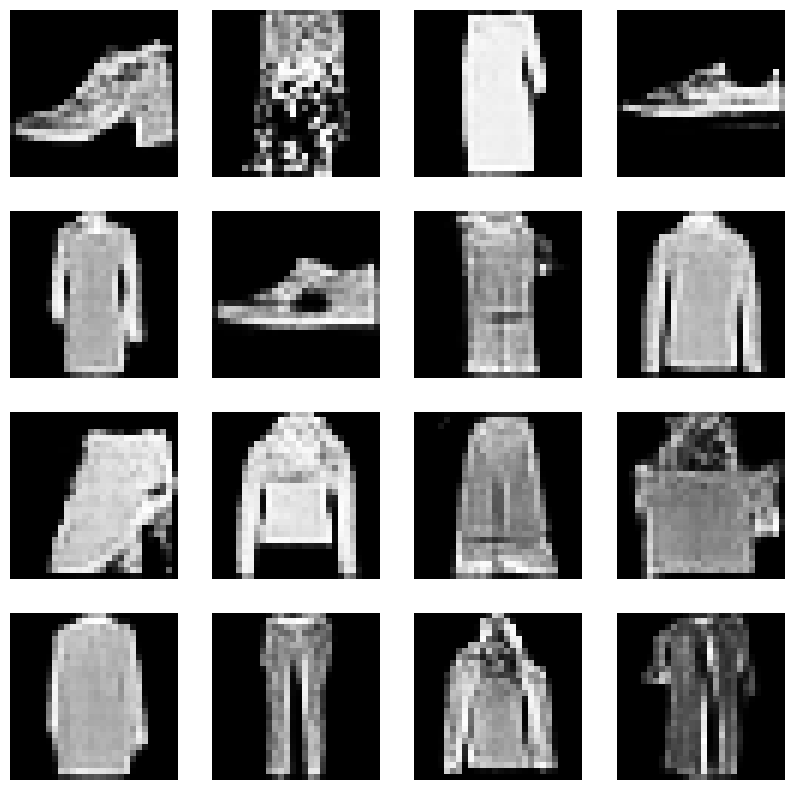

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - d_loss: 1.3368 - g_loss: 0.7675
Epoch 47/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3354 - g_loss: 0.7676
Epoch 48/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - d_loss: 1.3344 - g_loss: 0.7679
Epoch 49/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3328 - g_loss: 0.7636
Epoch 50/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3333 - g_loss: 0.7678
Epoch 51/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - d_loss: 1.3338 - g_loss: 0.7735

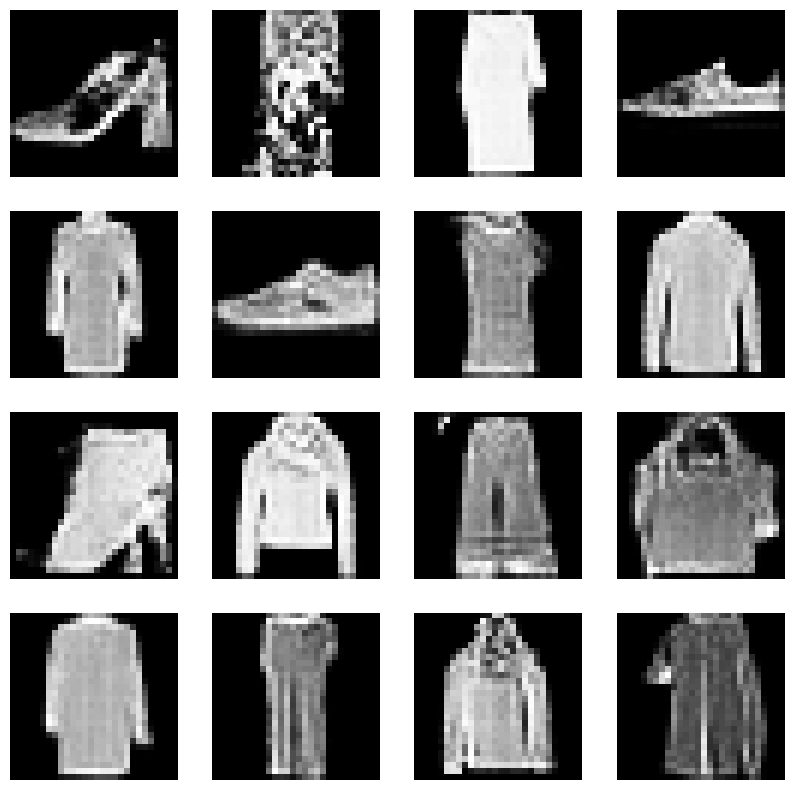

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - d_loss: 1.3339 - g_loss: 0.7733
Epoch 52/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3313 - g_loss: 0.7693
Epoch 53/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3328 - g_loss: 0.7767
Epoch 54/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3313 - g_loss: 0.7728
Epoch 55/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - d_loss: 1.3292 - g_loss: 0.7695
Epoch 56/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - d_loss: 1.3298 - g_loss: 0.7716

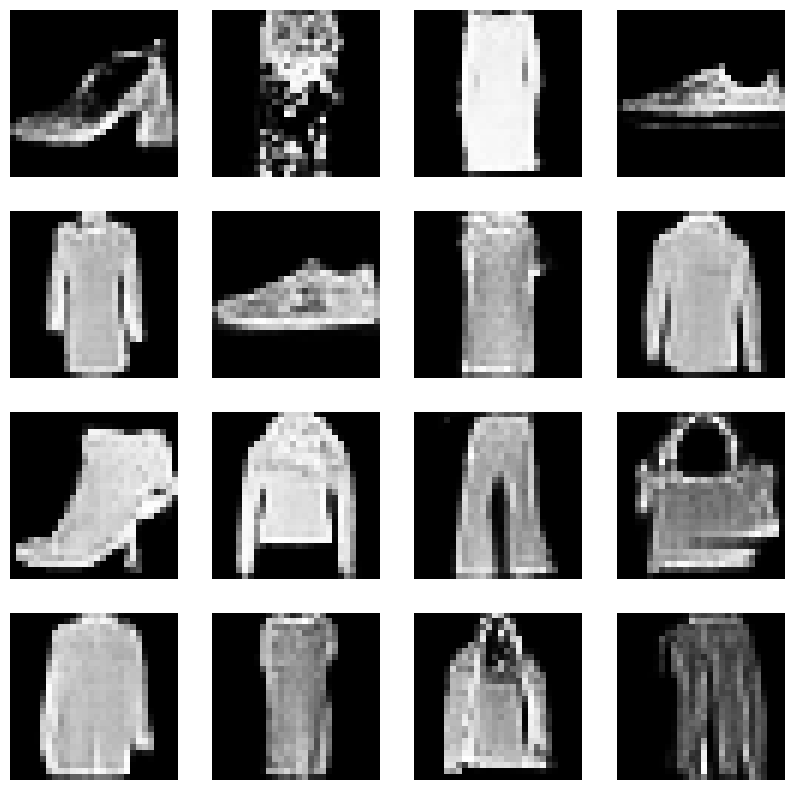

235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3302 - g_loss: 0.7720
Epoch 57/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3289 - g_loss: 0.7720
Epoch 58/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3284 - g_loss: 0.7809
Epoch 59/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - d_loss: 1.3232 - g_loss: 0.7702
Epoch 60/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3285 - g_loss: 0.7772
Epoch 61/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - d_loss: 1.3263 - g_loss: 0.7746

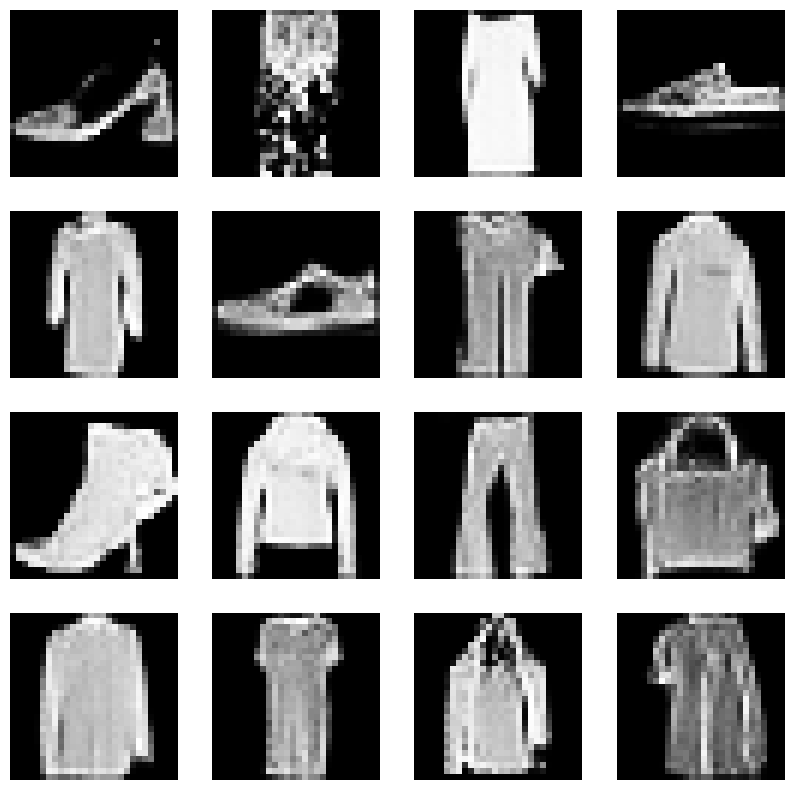

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - d_loss: 1.3263 - g_loss: 0.7755
Epoch 62/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3274 - g_loss: 0.7781
Epoch 63/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3257 - g_loss: 0.7766
Epoch 64/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3232 - g_loss: 0.7738
Epoch 65/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3236 - g_loss: 0.7771
Epoch 66/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - d_loss: 1.3226 - g_loss: 0.7785

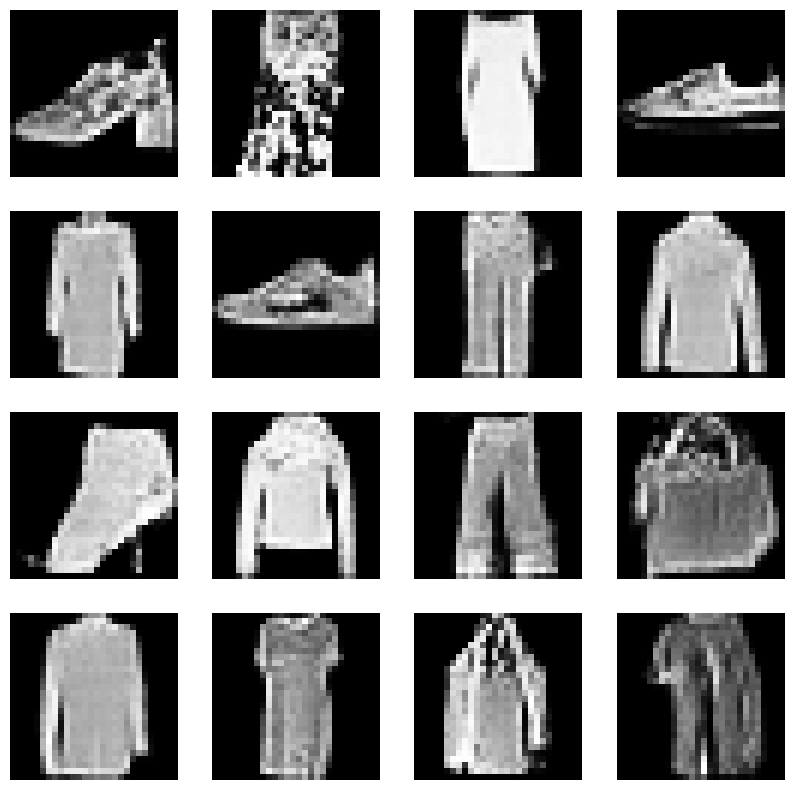

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - d_loss: 1.3222 - g_loss: 0.7787
Epoch 67/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3235 - g_loss: 0.7784
Epoch 68/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3243 - g_loss: 0.7769
Epoch 69/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3204 - g_loss: 0.7780
Epoch 70/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3243 - g_loss: 0.7780
Epoch 71/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - d_loss: 1.3232 - g_loss: 0.7856

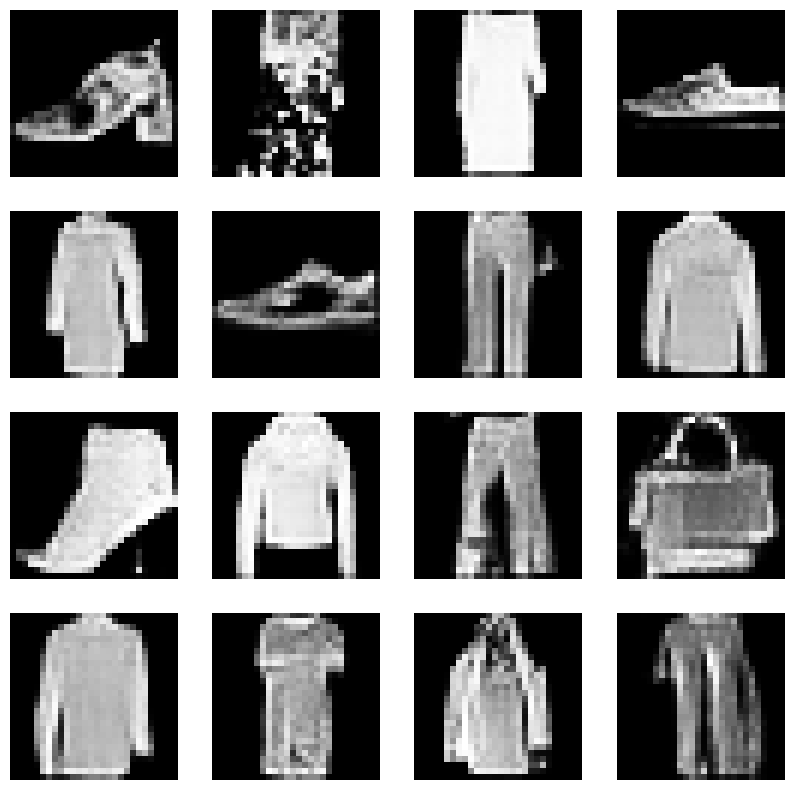

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - d_loss: 1.3229 - g_loss: 0.7847
Epoch 72/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3214 - g_loss: 0.7813
Epoch 73/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - d_loss: 1.3198 - g_loss: 0.7807
Epoch 74/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3202 - g_loss: 0.7816
Epoch 75/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3178 - g_loss: 0.7839
Epoch 76/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - d_loss: 1.3198 - g_loss: 0.7841

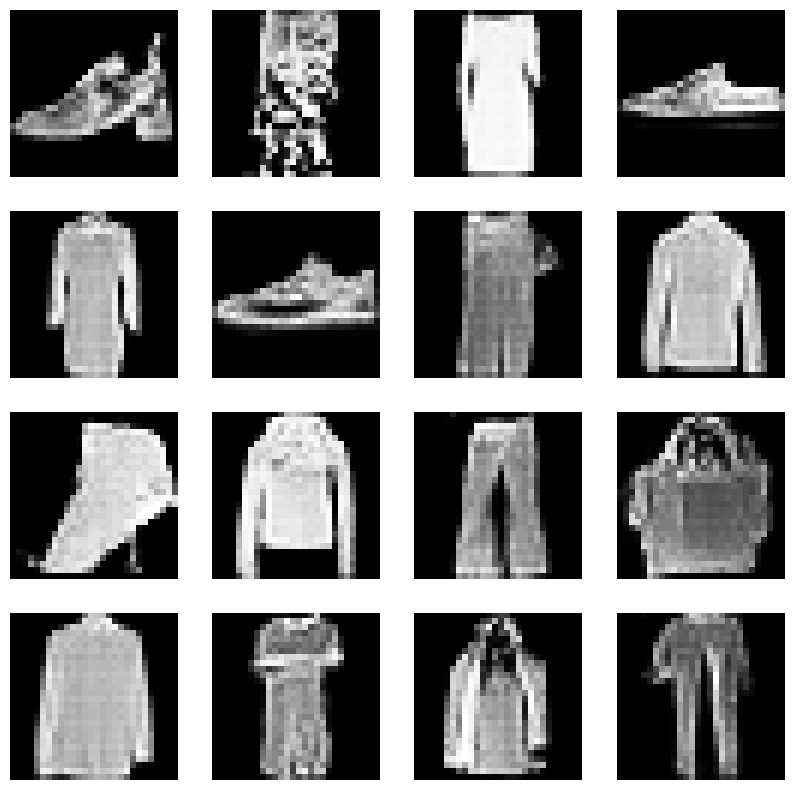

235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3202 - g_loss: 0.7849
Epoch 77/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3174 - g_loss: 0.7797
Epoch 78/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3242 - g_loss: 0.7817
Epoch 79/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3176 - g_loss: 0.7868
Epoch 80/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3181 - g_loss: 0.7829
Epoch 81/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - d_loss: 1.3190 - g_loss: 0.7877

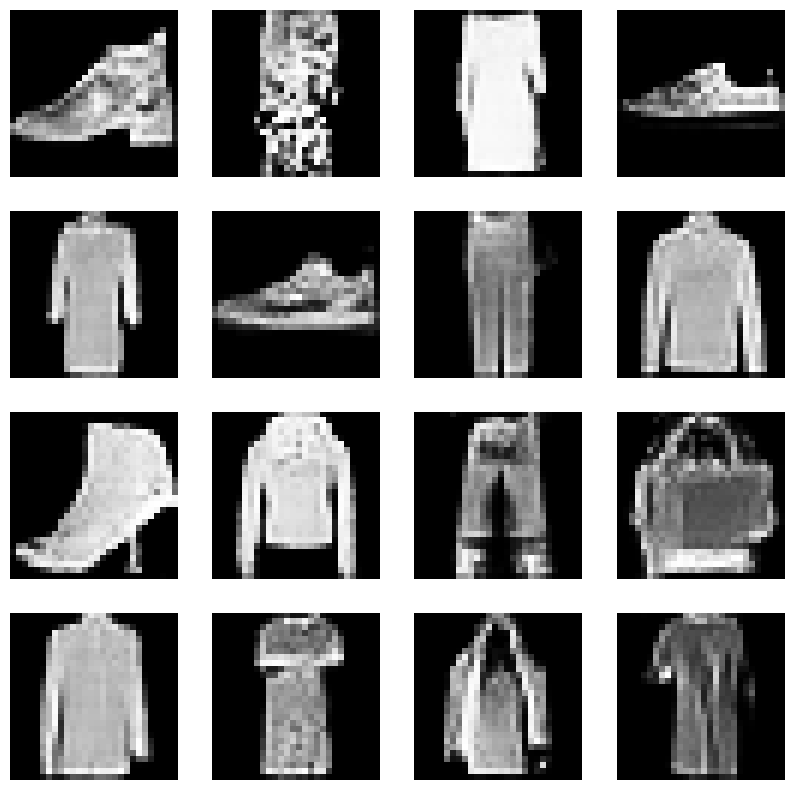

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - d_loss: 1.3192 - g_loss: 0.7873
Epoch 82/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3214 - g_loss: 0.7876
Epoch 83/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3175 - g_loss: 0.7826
Epoch 84/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3160 - g_loss: 0.7845
Epoch 85/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3167 - g_loss: 0.7843
Epoch 86/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - d_loss: 1.3154 - g_loss: 0.7850

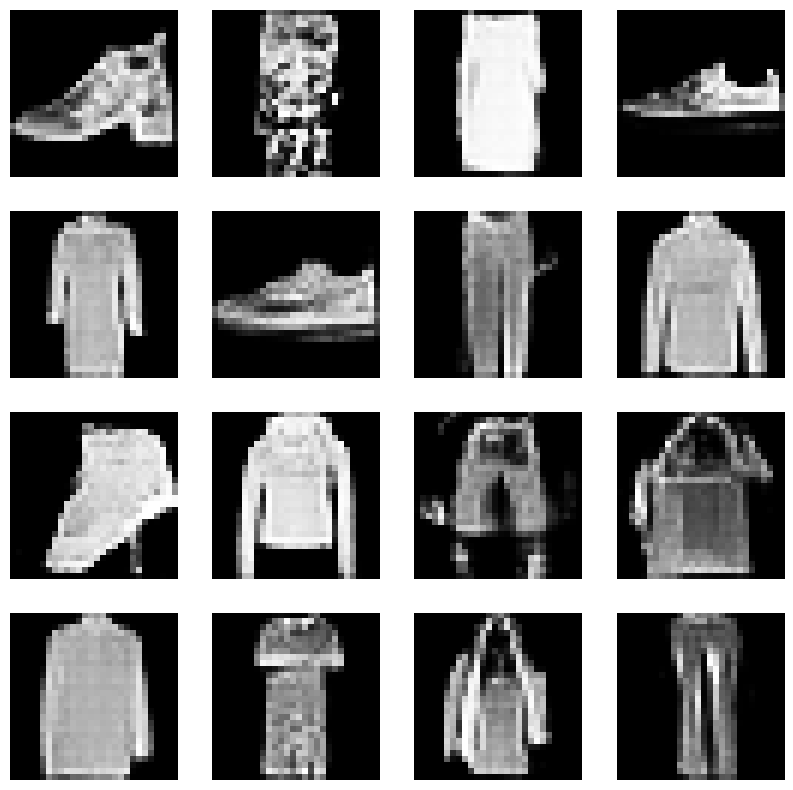

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - d_loss: 1.3152 - g_loss: 0.7852
Epoch 87/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3166 - g_loss: 0.7904
Epoch 88/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3166 - g_loss: 0.7892
Epoch 89/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3131 - g_loss: 0.7886
Epoch 90/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3152 - g_loss: 0.7883
Epoch 91/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - d_loss: 1.3178 - g_loss: 0.7890

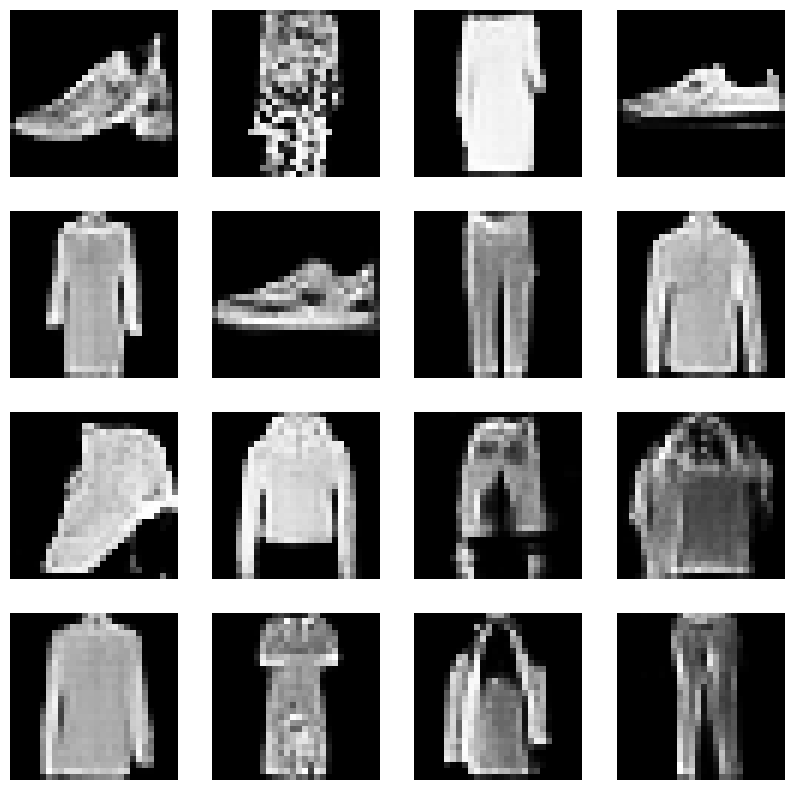

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - d_loss: 1.3173 - g_loss: 0.7881
Epoch 92/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3137 - g_loss: 0.7928
Epoch 93/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3107 - g_loss: 0.7910
Epoch 94/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3122 - g_loss: 0.7932
Epoch 95/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - d_loss: 1.3120 - g_loss: 0.7907
Epoch 96/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - d_loss: 1.3140 - g_loss: 0.7902

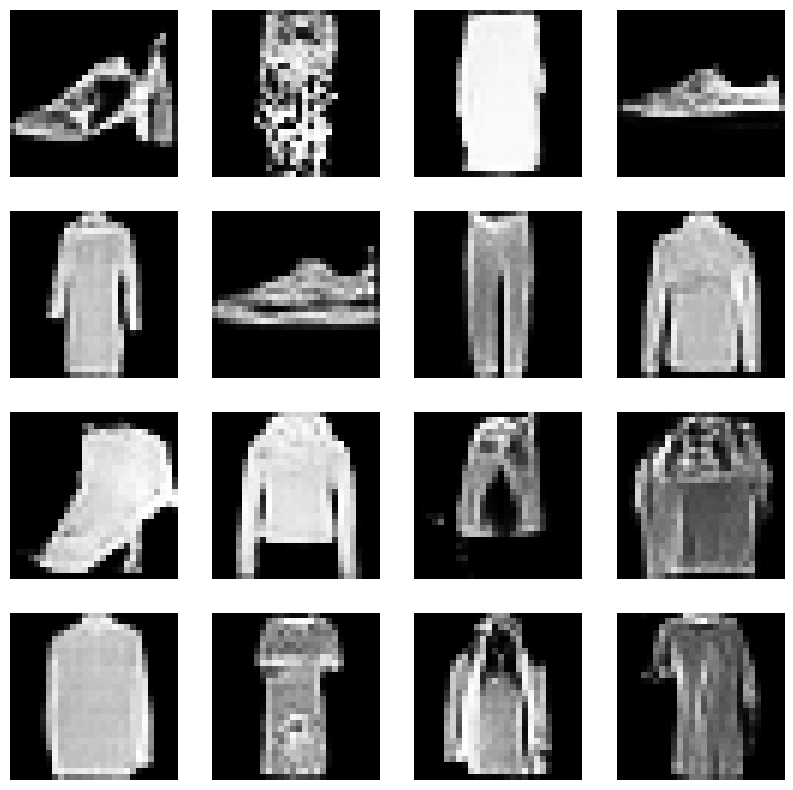

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - d_loss: 1.3143 - g_loss: 0.7911
Epoch 97/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3088 - g_loss: 0.7918
Epoch 98/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3113 - g_loss: 0.7979
Epoch 99/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3139 - g_loss: 0.7942
Epoch 100/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3088 - g_loss: 0.7937


In [ ]:
history = gan.fit(train_dataset, epochs=EPOCH, callbacks=[ImageCallback()])

# 6. Evaluate the model and save it

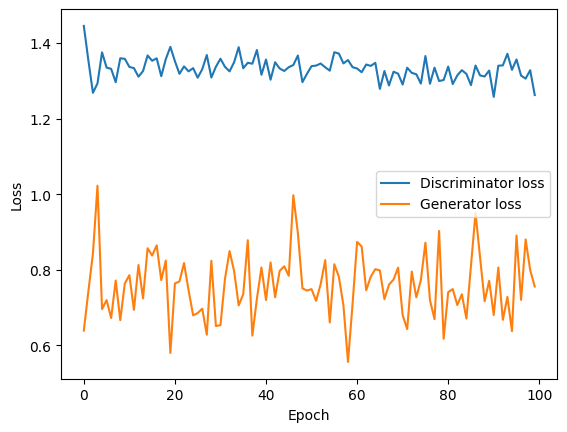

In [ ]:
plt.plot(history.history['d_loss'], label='Discriminator loss')
plt.plot(history.history['g_loss'], label='Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Test the generator
noise = tf.random.normal([25, LATENT_DIM])
generated_images = generator(noise)
generated_images = (generated_images * 127.5) + 127.5 # denormalize

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

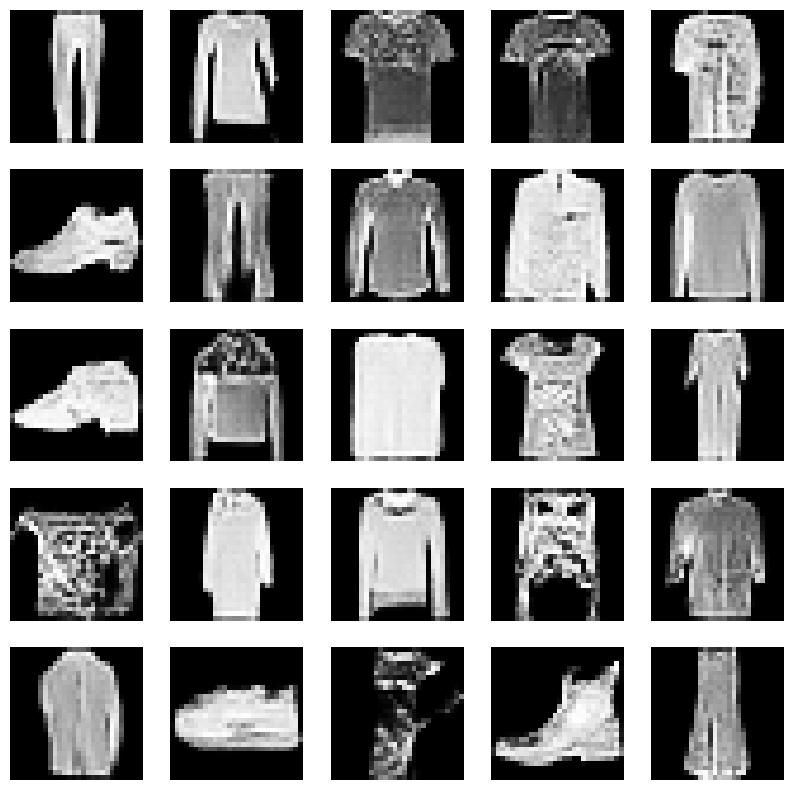

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(generated_images[i].numpy().astype("uint8"), cmap="gray")
  plt.axis("off")
plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
generator.save("/content/drive/My Drive/fashion_gan_generator.h5")